# 1. EDA and Preprocessing

In [4]:
import os
import glob
import time
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from tqdm import tqdm

### 1. PATH set

In [2]:
# Data from AI HUB
BASE_DIR = r"E:\한국인 감정인식을 위한 복합 영상"
TRAIN_PATH = os.path.join(BASE_DIR, "Training")
TEST_PATH = os.path.join(BASE_DIR, "Validation")
NEW_BASE = r"E:\PCP"

### 2. ZIP Extract

In [151]:
# Train ZIP
train_label_list = [label for label in os.listdir(TRAIN_PATH) if "[라벨]" in label]
train_source_list = [source for source in os.listdir(TRAIN_PATH) if "[원천]" in source]
# Test ZIP
test_label_list = [label for label in os.listdir(TEST_PATH) if "[라벨]" in label]
test_source_list = [source for source in os.listdir(TEST_PATH) if "[원천]" in source]

In [4]:
# 한국어 인코딩 적용 후, 압축 해제
def unzip_kor(source_file: str, dest_path: str)->None:
    with zipfile.ZipFile(source_file, "r") as zf:
        zipInfo = zf.infolist()
        for member in zipInfo:
            member.filename = member.filename.encode("cp437").decode("euc-kr")
            zf.extract(member, dest_path)

In [20]:
# Train Label
for zip_path in tqdm(train_label_list):
    zip_path = os.path.join(TRAIN_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, "Train_Label"))
# Test Label
for zip_path in tqdm(test_label_list):
    zip_path = os.path.join(TEST_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, "Test_Label"))

100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


In [5]:
# Train Source
for zip_path in tqdm(train_source_list):
    dir_name = zip_path[11:13]
    zip_path = os.path.join(TRAIN_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, os.path.join("Train", dir_name)))
# Test Source
for zip_path in tqdm(test_source_list):
    dir_name = zip_path[11:13]
    zip_path = os.path.join(TEST_PATH, zip_path)
    unzip_kor(zip_path, os.path.join(NEW_BASE, os.path.join("Test", dir_name)))

100%|██████████| 7/7 [48:27<00:00, 415.42s/it]


### 3. EDA
게시자 ID Hash_성별_연령_감정_배경_업로드 번호 

In [81]:
# conver DataFrame
train_df = []
for train in os.listdir(NEW_BASE+"/Train"): train_df.append(pd.DataFrame({"PATH":os.listdir(NEW_BASE+f"/Train/{train}")}))
train_df = pd.concat(train_df, axis=0)
train_df = train_df.reset_index(drop=True)
train_df = pd.concat([train_df, train_df["PATH"].str.split("_", expand=True).iloc[:, 1:4].rename(columns={1:"성별", 2:"나이", 3:"Label"})], axis=1)

test_df = []
for test in os.listdir(NEW_BASE+"/Test"): test_df.append(pd.DataFrame({"PATH":os.listdir(NEW_BASE+f"/Test/{test}")}))
test_df = pd.concat(test_df, axis=0)
test_df = test_df.reset_index(drop=True)
test_df = pd.concat([test_df, test_df["PATH"].str.split("_", expand=True).iloc[:, 1:4].rename(columns={1:"성별", 2:"나이", 3:"Label"})], axis=1)

print(f"Cols: {train_df.columns.tolist()}\nTrain: {train_df.shape}\nTest: {test_df.shape}")

Cols: ['PATH', '성별', '나이', 'Label']
Train: (417052, 4)
Test: (52139, 4)


In [102]:
# Save DF
train_df.to_csv("../Ref_Data/emtion_train.csv", encoding="utf8", index=False)
test_df.to_csv("../Ref_Data/emotion_test.csv", encoding="utf8", index=False)

### 4. EDA
#### 4-1. 전체 라벨 분포

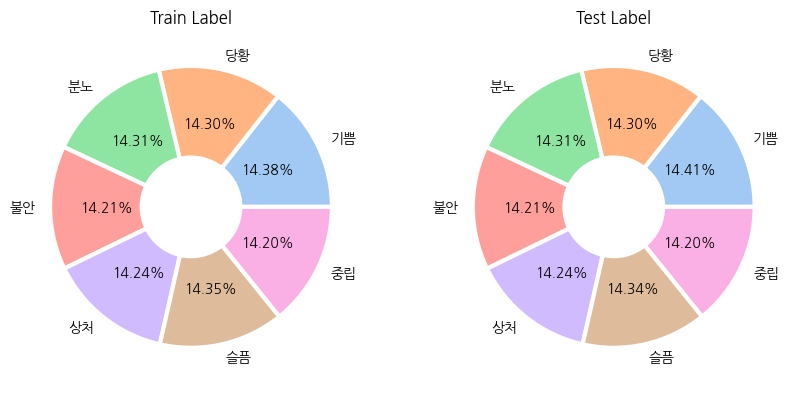

In [215]:
train_gb = train_df.groupby("Label")["PATH"].count()
test_gb = test_df.groupby("Label")["PATH"].count()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
wedgeprops = {"width":0.65, "edgecolor":"w", "linewidth":3}
cp = sns.color_palette("pastel", n_colors=7)
fontdict = {"weight":"bold"}

ax[0].pie(train_gb.values, labels=train_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[0].set_title("Train Label", fontdict=fontdict)

ax[1].pie(test_gb.values, labels=test_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[1].set_title("Test Label", fontdict=fontdict)

plt.show()

#### 4-2. 라벨별 샘플

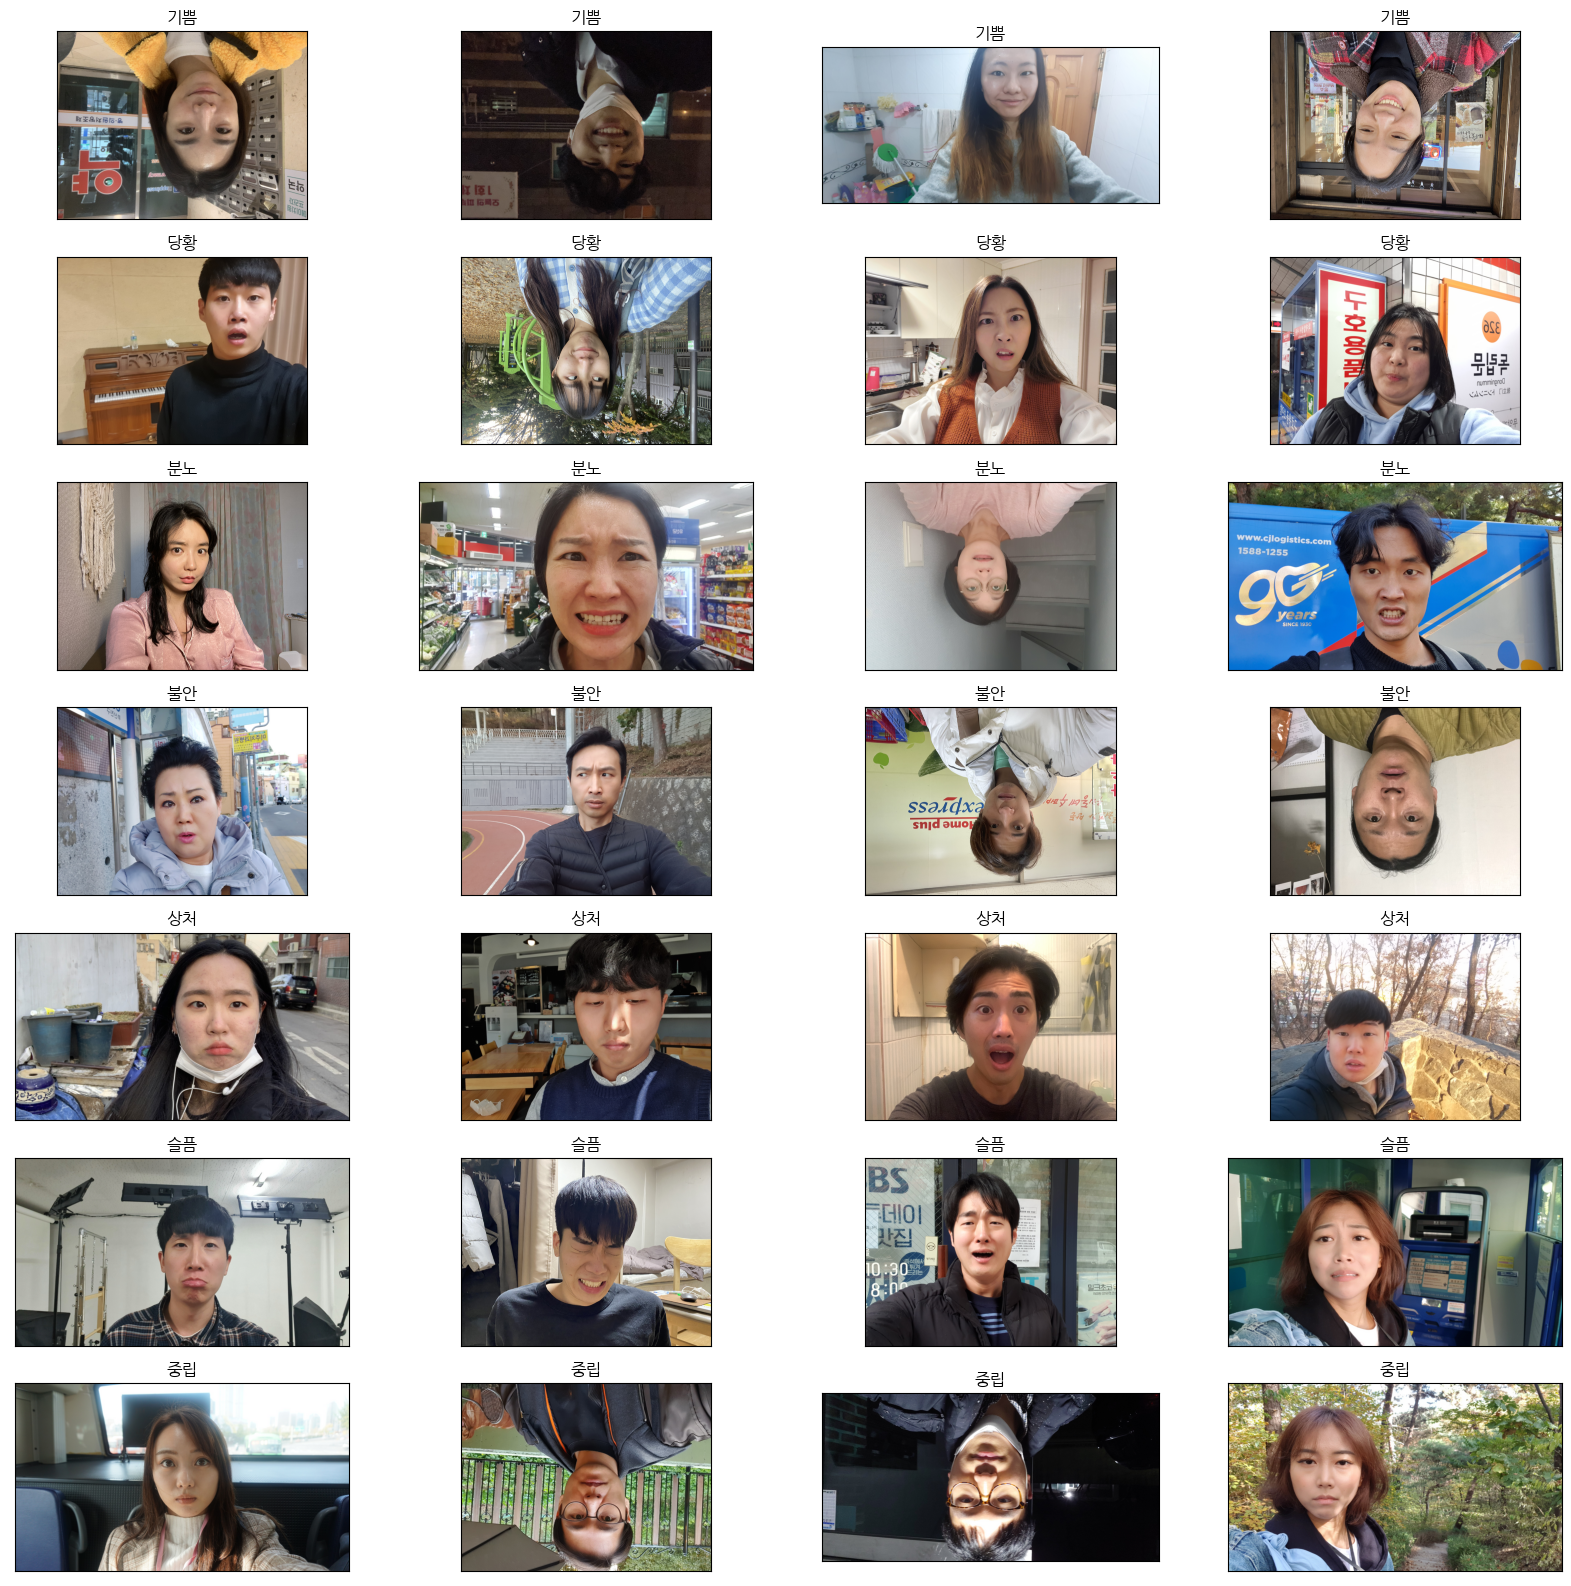

In [191]:
labels = os.listdir(NEW_BASE+"/Train")
plt.figure(figsize=(20, 20))
idx = 0
for ridx in range(0, len(labels)):
    for cidx in range(0, 4):
        emotion_sample = train_df[train_df["Label"]==labels[ridx]].sample(1)
        plt.subplot(7, 4, idx+1)
        plt.imshow(plt.imread(os.path.join(NEW_BASE, "Train", labels[ridx], emotion_sample["PATH"].values[0])))
        plt.title(emotion_sample["Label"].values[0])
        plt.xticks([])
        plt.yticks([])
        idx += 1

#### 4.3 나이별 분포

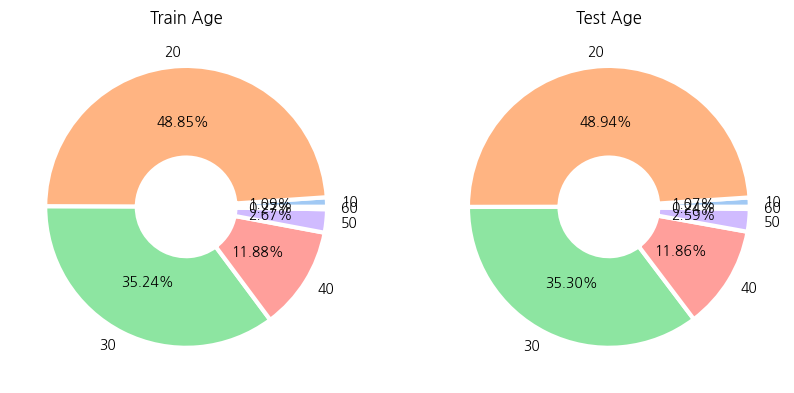

In [214]:
train_gb = train_df["나이"].value_counts().sort_index()
test_gb = test_df["나이"].value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
wedgeprops = {"width":0.65, "edgecolor":"w", "linewidth":3}
cp = sns.color_palette("pastel", n_colors=7)
fontdict = {"weight":"bold"}

ax[0].pie(train_gb.values, labels=train_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[0].set_title("Train Age", fontdict=fontdict)

ax[1].pie(test_gb.values, labels=test_gb.index, autopct="%.2f%%", wedgeprops=wedgeprops, colors=cp)
ax[1].set_title("Test Age", fontdict=fontdict)

plt.show()

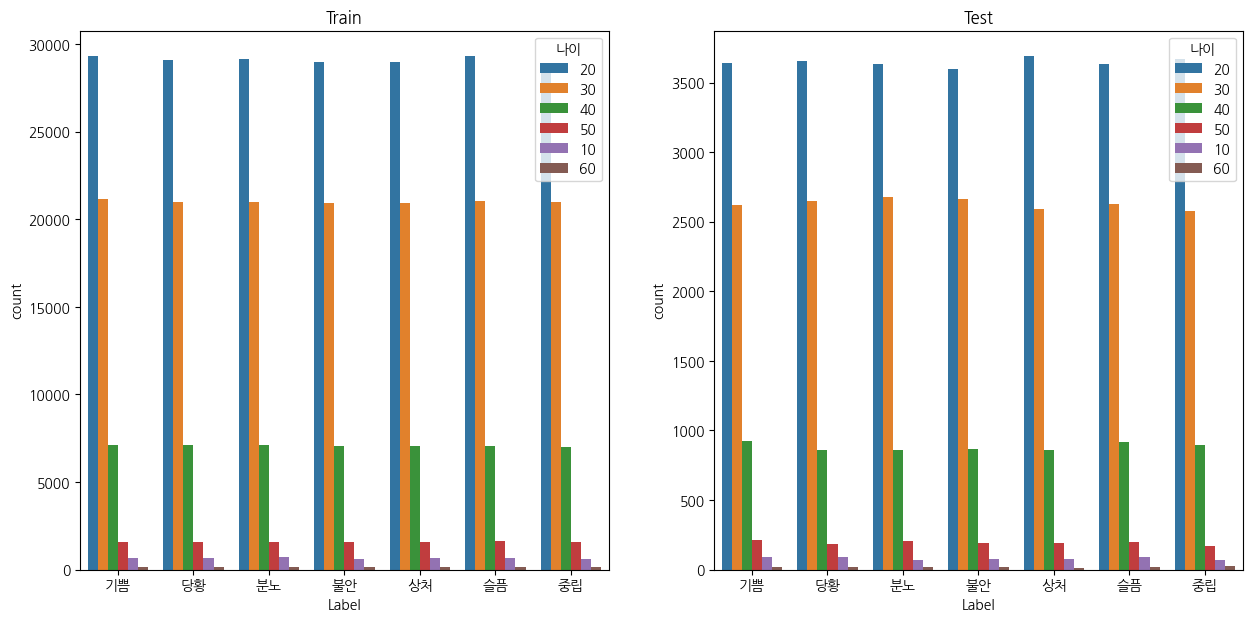

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(train_df, x="Label", hue="나이", ax=ax[0]).set_title("Train")
sns.countplot(test_df, x="Label", hue="나이", ax=ax[1]).set_title("Test")
plt.show()

#### 4.4 성별 분포

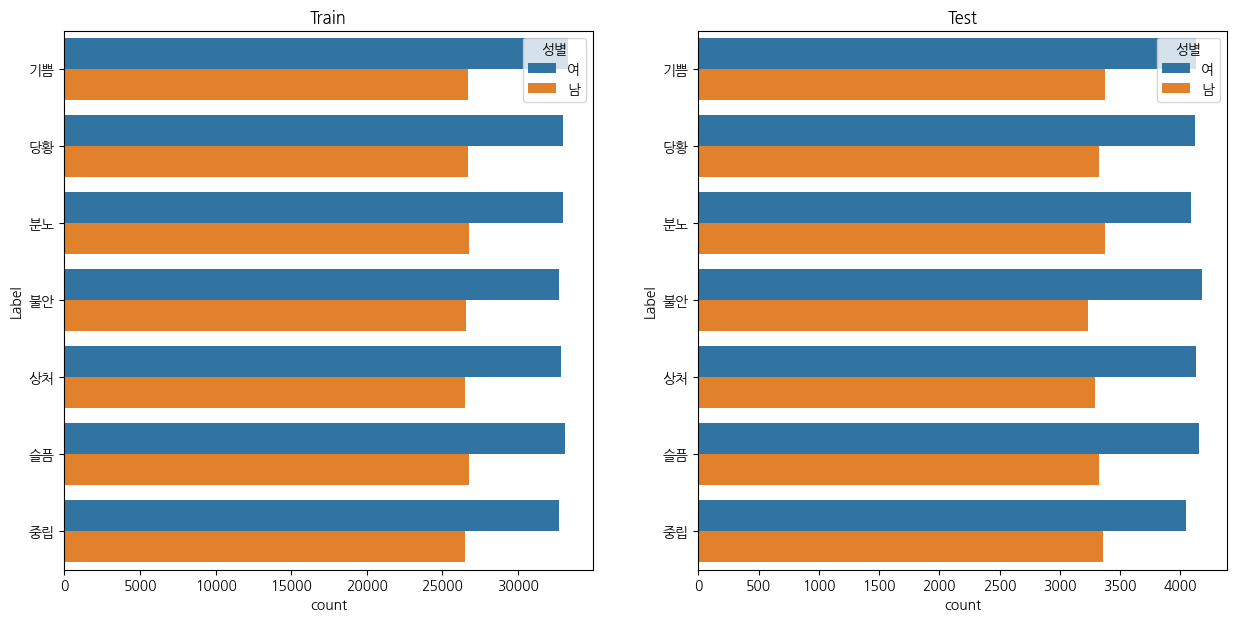

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(train_df, y="Label", hue="성별", ax=ax[0]).set_title("Train")
sns.countplot(test_df, y="Label", hue="성별", ax=ax[1]).set_title("Test")
plt.show()

### 5. Label

In [13]:
train = pd.read_csv(r"../Ref_Data/emtion_train.csv")
val = pd.read_csv(r"../Ref_Data/emotion_test.csv")
train_json = os.listdir(os.path.join(NEW_BASE, "Train_Label"))
test_json = os.listdir(os.path.join(NEW_BASE, "Test_Label"))

In [61]:
# json to df
train_json_df = []
for idx in range(0, len(train_json)):
    with open(os.path.join(NEW_BASE, "Train_Label", train_json[idx])) as f:
        temp_json = json.load(f)
    train_json_df.append(pd.DataFrame(temp_json))
train_json_df = pd.concat(train_json_df, axis=0).reset_index(drop=True)
    
test_json_df = []
for idx in range(0, len(test_json)):
    with open(os.path.join(NEW_BASE, "Test_Label", test_json[idx])) as f:
        temp_json = json.load(f)
    test_json_df.append(pd.DataFrame(temp_json))
test_json_df = pd.concat(test_json_df, axis=0).reset_index(drop=True)

In [127]:
# 평균 anchor box coor
def avg_annot(cols):
    aA, aB, aC = cols[0], cols[1], cols[2]
    aA, aB, aC = aA["boxes"], aB["boxes"], aC["boxes"]
    avg_dict = {}
    for annot in ["maxX", "maxY", "minX", "minY"]:
        avg = (aA[annot] + aB[annot] + aC[annot]) / 3
        avg_dict[annot] = avg
    return avg_dict

In [130]:
train_json_df["avg_annot"] = train_json_df[["annot_A", "annot_B", "annot_C"]].apply(avg_annot, axis=1)
test_json_df["avg_annot"] = test_json_df[["annot_A", "annot_B", "annot_C"]].apply(avg_annot, axis=1)

In [139]:
train_df = pd.merge(
    left=train, right=train_json_df[["filename", "avg_annot"]],
    left_on=["PATH"], right_on=["filename"], how="left"
)[["PATH", "avg_annot", "Label"]]

val_df = pd.merge(
    left=val, right=test_json_df[["filename", "avg_annot"]],
    left_on=["PATH"], right_on=["filename"], how="left"
)[["PATH", "avg_annot", "Label"]]

### 6. For VOLO

In [309]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000

convert_dict = {
    "기쁨":0,
    "당황":1,
    "불안":1,
    "분노":2,
    "상처":3,
    "슬픔":3,
    "중립":4
}

#### 6-1. Mov dir
기존 폴더 -> YOLO 파인 튜닝 형식으로 변환

In [161]:
# mov dir (Train)
for path in train_df["PATH"]:
    path = os.path.join(NEW_BASE, "Train", path[70:72], path)
    shutil.move(path, os.path.join(NEW_BASE, "Train"))
    
# mov dir (Test)
for path in val_df["PATH"]:
    path = os.path.join(NEW_BASE, "Test", path[70:72], path)
    shutil.move(path, os.path.join(NEW_BASE, "Test"))

#### 6-2. Convert COCO format

In [ ]:
YOLO_Train_Path = os.path.join(NEW_BASE, "Train")
YOLO_Val_Path = os.path.join(NEW_BASE, "Test")

In [253]:
def get_img_size_train(path):
    try:
        path = os.path.join(YOLO_Train_Path, path)
        img = Image.open(path)
        return img.size
    except: return None
def get_img_size_val(path):
    try:
        path = os.path.join(YOLO_Val_Path, path)
        img = Image.open(path)
        return img.size
    except: return None

def get_X(cols): return (col["maxX"] + col["minX"])/2
def get_Y(col): return (col["maxY"] + col["minY"])/2
def get_W(col): return (col["maxX"] - col["minX"])
def get_H(col): return (col["maxY"] - col["minY"])

In [ ]:
# Make new feature for VOLO fine-tunning
for df in [train_df, val_df]:
    df["X"] = df["avg_annot"].apply(get_X)
    df["Y"] = df["avg_annot"].apply(get_Y)
    df["W"] = df["avg_annot"].apply(get_W)
    df["H"] = df["avg_annot"].apply(get_H)

In [ ]:
# Train
train_df["SIZE"] = train_df["PATH"].apply(get_img_size_train)
train_df["rW"] = train_df["SIZE"].apply(lambda x: x[0])
train_df["rH"] = train_df["SIZE"].apply(lambda x: x[1])
train_df["X"] = train_df["X"]/train_df["rW"]
train_df["Y"] = train_df["Y"]/train_df["rH"]
train_df["W"] = train_df["W"]/train_df["rW"]
train_df["H"] = train_df["H"]/train_df["rH"]
# Validation
val_df["SIZE"] = val_df["PATH"].apply(get_img_size_val)
val_df["rW"] = val_df["SIZE"].apply(lambda x: x[0])
val_df["rH"] = val_df["SIZE"].apply(lambda x: x[1])
val_df["X"] = val_df["X"]/val_df["rW"]
val_df["Y"] = val_df["Y"]/val_df["rH"]
val_df["W"] = val_df["W"]/val_df["rW"]
val_df["H"] = val_df["H"]/val_df["rH"]

YOLO_Train = train_df[["PATH", "X", "Y", "W", "H", "Label"]]
YOLO_Val = val_df[["PATH", "X", "Y", "W", "H", "Label"]]

# 원본 이미지 정보
train_df.to_csv("../Ref_Data/RAW_TRAIN.csv", index=False)
val_df.to_csv("../Ref_Data/RAW_VAL.csv", index=False)
# YOLO 이미지 정보
YOLO_Train.to_csv("../Ref_Data/YOLO_Train.csv", index=False)
YOLO_Val.to_csv("../Ref_Data/YOLO_Val.csv", index=False)

In [305]:
def formatted_save_Train(cols):
    path = cols[0].split(".")[0]
    path = os.path.join(YOLO_Train_Path, path)
    with open(path+".txt", "w") as txt:
        txt.write(f"{cols[5]} {cols[1]} {cols[2]} {cols[3]} {cols[4]}")
YOLO_Train["Label"] = YOLO_Train["Label"].apply(lambda x: convert_dict[x])
YOLO_Train.apply(formatted_save_Train, axis=1)

def formatted_save_Val(cols):
    path = cols[0].split(".")[0]
    path = os.path.join(YOLO_Val_Path, path)
    with open(path+".txt", "w") as txt:
        txt.write(f"{cols[5]} {cols[1]} {cols[2]} {cols[3]} {cols[4]}")
YOLO_Val["Label"] = YOLO_Val["Label"].apply(lambda x: convert_dict[x])
YOLO_Val.apply(formatted_save_Val, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
52134    None
52135    None
52136    None
52137    None
52138    None
Length: 52139, dtype: object

## NOTE!

In [380]:
note = pd.merge(
    left=train, right = train_json_df[["filename", "annot_A", "annot_B", "annot_C", "avg_annot"]],
    left_on=["PATH"], right_on=["filename"], how="left"
)

note = note.sample(1)
note = note[["PATH", "annot_A", "annot_B", "annot_C", "avg_annot"]]

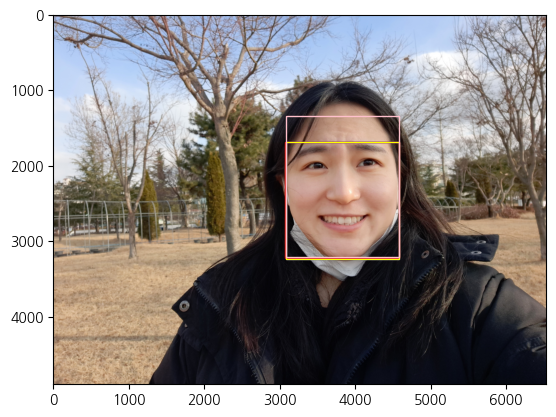

In [402]:
fix, ax = plt.subplots()
img = plt.imread(os.path.join(YOLO_Train_Path, note["PATH"].values[0]))
plt.imshow(img)

# Annotate A
ax.add_patch(
    patches.Rectangle(
        (note["annot_A"].values[0]["boxes"]["minX"], note["annot_A"].values[0]["boxes"]["minY"]),
        note["annot_A"].values[0]["boxes"]["maxX"] - note["annot_A"].values[0]["boxes"]["minX"],
        note["annot_A"].values[0]["boxes"]["maxY"] - note["annot_A"].values[0]["boxes"]["minY"],
        fill=False, edgecolor="red"
    )
)
# Annotate B
ax.add_patch(
    patches.Rectangle(
        (note["annot_B"].values[0]["boxes"]["minX"], note["annot_A"].values[0]["boxes"]["minY"]),
        note["annot_B"].values[0]["boxes"]["maxX"] - note["annot_A"].values[0]["boxes"]["minX"],
        note["annot_B"].values[0]["boxes"]["maxY"] - note["annot_A"].values[0]["boxes"]["minY"],
        fill=False, edgecolor="blue"
    )
)
# Annotate C
ax.add_patch(
    patches.Rectangle(
        (note["annot_B"].values[0]["boxes"]["minX"], note["annot_A"].values[0]["boxes"]["minY"]),
        note["annot_B"].values[0]["boxes"]["maxX"] - note["annot_A"].values[0]["boxes"]["minX"],
        note["annot_B"].values[0]["boxes"]["maxY"] - note["annot_A"].values[0]["boxes"]["minY"],
        fill=False, edgecolor="yellow"
    )
)
# Annotate Avg
ax.add_patch(
    patches.Rectangle(
        (note["avg_annot"].values[0]["minX"], note["avg_annot"].values[0]["minY"]),
        note["avg_annot"].values[0]["maxX"] - note["avg_annot"].values[0]["minX"],
        note["avg_annot"].values[0]["maxY"] - note["avg_annot"].values[0]["minY"],
        fill=False, edgecolor="pink"
    )
)

plt.show()